# NBA Data :: Predicting Game Points with Multiple Linear Regression

## Trevor Rowland :: 3-6-2025

This notebook aims to predict the amount of points in a given NBA game from historical game data.

## Table of Contents

## Importing Packages and Data

In [2]:
import numpy as np
import pandas as pd

import pandas as pd 
import numpy as np

# Set display options to show all columns and a large width
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', 1000)  # Adjust the width as needed

%matplotlib inline
import matplotlib.pylab as plt


from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from kneed import KneeLocator

In [3]:
gdrive_url = 'https://drive.google.com/file/d/1U2UaHWRSkUXfJBn4kBHPYttd3dvw_CZF/view?usp=drive_link'

file_id = '1U2UaHWRSkUXfJBn4kBHPYttd3dvw_CZF'
url = f'https://drive.google.com/uc?id={file_id}'
df = pd.read_csv(url, encoding='utf-8')
df = df[df['season'].str[:4].astype(int) > 2012] # Remove old seasons (this was causing issues)
df.head()

,game_id,season,team_id,team_name,tri_code,team_slug,minutes,field_goals_made,field_goals_attempted,field_goals_percentage,three_pointers_made,three_pointers_attempted,three_pointers_percentage,free_throws_made,free_throws_attempted,free_throws_percentage,rebounds_offensive,rebounds_defensive,rebounds_total,steals,blocks,turnovers,fouls_personal,points,plus_minus_points,estimated_offensive_rating,offensive_rating,estimated_defensive_rating,defensive_rating,estimated_net_rating,net_rating,assist_percentage,assist_to_turnover,assist_ratio,offensive_rebound_percentage,defensive_rebound_percentage,rebound_percentage,estimated_team_turnover_percentage,turnover_ratio,effective_field_goal_percentage,true_shooting_percentage,usage_percentage,estimated_usage_percentage,estimated_pace,pace,pace_per40,possessions,p_i_e,distance,rebound_chances_offensive,rebound_chances_defensive,rebound_chances_total,touches,secondary_assists,free_throw_assists,passes,assists,contested_field_goals_made,contested_field_goals_attempted,contested_field_goal_percentage,uncontested_field_goals_made,uncontested_field_goals_attempted,uncontested_field_goals_percentage,field_goal_percentage,defended_at_rim_field_goals_made,defended_at_rim_field_goals_attempted,defended_at_rim_field_goal_percentage,opponent_points,is_home_team,won_game,is_playoff_game,is_regular_game
12495,41300405,2013-14,1610612759,Spurs,SAS,spurs,240:00,37.0,78.0,0.474,12.0,26.0,0.462,18.0,23.0,0.783,6.0,34.0,40.0,5.0,4.0,8.0,21.0,104.0,17.0,115.4,116.9,92.7,97.8,22.7,19.1,0.676,3.13,20.6,0.178,0.750,0.473,8.877,9.0,0.551,0.590,1.0,0.200,92.00,89.0,74.17,89.0,0.622,17.60,32.0,61.0,90.0,467.0,4.0,1.0,357.0,25.0,18.0,38.0,0.474,19.0,40.0,0.475,0.474,15.0,24.0,0.625,87.0,1,1,1,0
12496,41300404,2013-14,1610612748,Heat,MIA,heat,240:00,32.0,71.0,0.451,9.0,22.0,0.409,13.0,20.0,0.650,6.0,21.0,27.0,7.0,1.0,13.0,25.0,86.0,-21.0,99.1,101.2,128.9,127.4,-29.8,-26.2,0.406,1.00,12.3,0.000,0.000,0.000,14.977,15.3,0.514,0.539,1.0,0.203,84.90,84.5,70.42,85.0,0.297,16.83,21.0,38.0,57.0,377.0,0.0,1.0,274.0,13.0,14.0,30.0,0.467,18.0,41.0,0.439,0.451,16.0,19.0,0.842,107.0,1,0,1,0
12497,41300403,2013-14,1610612748,Heat,MIA,heat,240:00,32.0,62.0,0.516,10.0,21.0,0.476,18.0,24.0,0.750,5.0,21.0,26.0,8.0,1.0,20.0,26.0,92.0,-19.0,105.1,108.2,128.9,129.1,-23.9,-20.8,0.531,0.85,15.5,0.229,0.733,0.462,22.841,23.5,0.597,0.634,1.0,0.199,86.82,85.5,71.25,85.0,0.365,16.36,21.0,40.0,57.0,361.0,2.0,0.0,256.0,17.0,16.0,31.0,0.516,16.0,31.0,0.516,0.516,14.0,20.0,0.700,111.0,1,0,1,0
12498,41300402,2013-14,1610612759,Spurs,SAS,spurs,240:00,36.0,82.0,0.439,12.0,26.0,0.462,12.0,20.0,0.600,11.0,26.0,37.0,7.0,1.0,11.0,20.0,96.0,-2.0,105.7,109.1,108.6,110.1,-2.9,-1.0,0.722,2.36,20.3,0.260,0.000,0.000,12.115,12.5,0.512,0.529,1.0,0.196,90.52,88.5,73.75,88.0,0.478,16.80,25.0,37.0,60.0,436.0,6.0,1.0,325.0,26.0,17.0,40.0,0.425,19.0,42.0,0.452,0.439,17.0,24.0,0.708,98.0,1,0,1,0
12499,41300401,2013-14,1610612759,Spurs,SAS,spurs,240:00,40.0,68.0,0.588,13.0,25.0,0.520,17.0,22.0,0.773,5.0,34.0,39.0,8.0,4.0,22.0,14.0,110.0,15.0,115.0,115.8,101.2,100.0,13.7,15.8,0.750,1.30,23.0,0.258,0.814,0.581,24.038,24.2,0.684,0.708,1.0,0.199,94.76,95.0,79.17,95.0,0.626,17.48,17.0,57.0,72.0,441.0,2.0,3.0,333.0,30.0,23.0,32.0,0.719,17.0,36.0,0.472,0.588,12.0,21.0,0.571,95.0,1,1,1,0


## Data Preprocessing

### PCA Results

In a PCA that Shake ran, we have the following lists of features:

In [4]:
feat_list_2 = ['possessions', 'contested_field_goals_made', 'is_home_team', 'estimated_team_turnover_percentage', 'defensive_rebound_percentage', 'defended_at_rim_field_goals_attempted', 'offensive_rebound_percentage', 'free_throws_made', 'estimated_usage_percentage', 'steals', 'free_throws_percentage', 'rebound_percentage', 'fouls_personal', 'effective_field_goal_percentage', 'assist_percentage', 'opponent_points']
feat_list_1 = ['defended_at_rim_field_goals_made', 'possessions', 'contested_field_goals_made', 'free_throws_percentage', 'fouls_personal', 'free_throws_attempted', 'rebound_chances_defensive', 'rebounds_offensive', 'contested_field_goals_attempted', 'is_home_team', 'estimated_team_turnover_percentage', 'defended_at_rim_field_goals_attempted', 'defended_at_rim_field_goal_percentage', 'rebound_percentage', 'free_throws_made', 'three_pointers_made', 'estimated_offensive_rating', 'defensive_rebound_percentage', 'assist_percentage', 'turnovers', 'opponent_points', 'passes', 'estimated_defensive_rating', 'estimated_pace', 'offensive_rebound_percentage', 'estimated_usage_percentage', 'touches', 'steals', 'effective_field_goal_percentage']

# Add Dependent Variables In:
feat_list_1.append('points')
feat_list_2.append('points')

We will create models of both `feat_list_1` and `feat_list_2` and compare the two.

In [5]:
df_numeric = df.select_dtypes('number') # Filter for only numbers

to_drop = ['game_id','team_id'] # Drop IDs
df_dropped_ids = df_numeric.drop(to_drop, axis=1).dropna()

df_pca_1 = df_dropped_ids[feat_list_1]
df_pca_2 = df_dropped_ids[feat_list_2]

df_pca_1.head()

,defended_at_rim_field_goals_made,possessions,contested_field_goals_made,free_throws_percentage,fouls_personal,free_throws_attempted,rebound_chances_defensive,rebounds_offensive,contested_field_goals_attempted,is_home_team,estimated_team_turnover_percentage,defended_at_rim_field_goals_attempted,defended_at_rim_field_goal_percentage,rebound_percentage,free_throws_made,three_pointers_made,estimated_offensive_rating,defensive_rebound_percentage,assist_percentage,turnovers,opponent_points,passes,estimated_defensive_rating,estimated_pace,offensive_rebound_percentage,estimated_usage_percentage,touches,steals,effective_field_goal_percentage,points
12495,15.0,89.0,18.0,0.783,21.0,23.0,61.0,6.0,38.0,1,8.877,24.0,0.625,0.473,18.0,12.0,115.4,0.750,0.676,8.0,87.0,357.0,92.7,92.00,0.178,0.200,467.0,5.0,0.551,104.0
12496,16.0,85.0,14.0,0.650,25.0,20.0,38.0,6.0,30.0,1,14.977,19.0,0.842,0.000,13.0,9.0,99.1,0.000,0.406,13.0,107.0,274.0,128.9,84.90,0.000,0.203,377.0,7.0,0.514,86.0
12497,14.0,85.0,16.0,0.750,26.0,24.0,40.0,5.0,31.0,1,22.841,20.0,0.700,0.462,18.0,10.0,105.1,0.733,0.531,20.0,111.0,256.0,128.9,86.82,0.229,0.199,361.0,8.0,0.597,92.0
12498,17.0,88.0,17.0,0.600,20.0,20.0,37.0,11.0,40.0,1,12.115,24.0,0.708,0.000,12.0,12.0,105.7,0.000,0.722,11.0,98.0,325.0,108.6,90.52,0.260,0.196,436.0,7.0,0.512,96.0
12499,12.0,95.0,23.0,0.773,14.0,22.0,57.0,5.0,32.0,1,24.038,21.0,0.571,0.581,17.0,13.0,115.0,0.814,0.750,22.0,95.0,333.0,101.2,94.76,0.258,0.199,441.0,8.0,0.684,110.0


In [6]:
df_pca_2.head()

,possessions,contested_field_goals_made,is_home_team,estimated_team_turnover_percentage,defensive_rebound_percentage,defended_at_rim_field_goals_attempted,offensive_rebound_percentage,free_throws_made,estimated_usage_percentage,steals,free_throws_percentage,rebound_percentage,fouls_personal,effective_field_goal_percentage,assist_percentage,opponent_points,points
12495,89.0,18.0,1,8.877,0.750,24.0,0.178,18.0,0.200,5.0,0.783,0.473,21.0,0.551,0.676,87.0,104.0
12496,85.0,14.0,1,14.977,0.000,19.0,0.000,13.0,0.203,7.0,0.650,0.000,25.0,0.514,0.406,107.0,86.0
12497,85.0,16.0,1,22.841,0.733,20.0,0.229,18.0,0.199,8.0,0.750,0.462,26.0,0.597,0.531,111.0,92.0
12498,88.0,17.0,1,12.115,0.000,24.0,0.260,12.0,0.196,7.0,0.600,0.000,20.0,0.512,0.722,98.0,96.0
12499,95.0,23.0,1,24.038,0.814,21.0,0.258,17.0,0.199,8.0,0.773,0.581,14.0,0.684,0.750,95.0,110.0


In [7]:
print(f'There are {df_pca_1.isna().sum().sum()} missing values in the first df of PCA features.')
print(f'There are {df_pca_2.isna().sum().sum()} missing values in the second df of PCA features.')

There are 0 missing values in the first df of PCA features.
There are 0 missing values in the second df of PCA features.


### Removing High Correlation

Now we need to remove the independent variables that are highly correlated with each other. To do this, we have a function we can define:

In [8]:
'''
This function drops highly correlated variables given a threshold.
It drops the variable with smaller variance.

It returns:
1. The variables that were dropped
2. The data without the dropped variables
'''

def drop_highly_correlated(data, threshold=.7):
    from dython.nominal import associations
    cor_matrix = associations(dataset=data, compute_only=True)['corr'].abs()
    #cor_matrix = data.corr().abs()
    sol = (cor_matrix.where(np.triu(np.ones(cor_matrix.shape), k=1).astype(bool))).unstack().dropna()

    to_drop=[]
    for i in range(len(sol[sol > threshold].index.tolist())):
        var1 = sol[sol >= threshold].index.tolist()[i][0]
        var2 = sol[sol >= threshold].index.tolist()[i][1]

        if(data[var1].var() < data[var2].var()): 
            to_drop.append(var1)
        else: 
            to_drop.append(var2)

    dropped_vars = list(set(to_drop))
    return dropped_vars, data.drop(dropped_vars, axis=1) # (list of dropped vars, resultant df)

And here is a function to get a correlation heatmap of the results to check our work later.

In [9]:
def my_corrplot(df, dep_var):
    import seaborn as sns
    from dython.nominal import associations

    # create a correlation matrix of all predictor variables using 'associations'
    corr_matrix = associations(dataset=df.drop(dep_var, axis=1), compute_only=True)['corr']

    # Mask upper triangle of the corr heatmap ???
    mask_upper = np.triu(np.ones_like(corr_matrix, dtype=bool))

    # Plot
    plt.figure(figsize=(44,44))
    sns.heatmap(corr_matrix, annot=True, mask=mask_upper, fmt='.2f', vmin=-1, vmax=1)
    plt.show()

Now with these functions, we can split the dataframe into 2 components: `X`, the independent features, and `y`, the dependent variable. Then we can plug these into the function and remove the multicollinearity in the dataset.

In [10]:
# Split the Data
y1 = df_pca_1['points']
X1 = df_pca_1.drop(columns=['points'], axis=1)

y2 = df_pca_2['points']
X2 = df_pca_2.drop(columns=['points'], axis=1)

# Remove Multicollinearity
res1 = drop_highly_correlated(X1)
res2 = drop_highly_correlated(X2)

nu_X1 = res1[1] # X values with no multicollinearity from PCA list 1
nu_X2 = res2[1] # X values with no multicollinearity from PCA list 2

# Squish Variables back together
nu_pca_df_1 = pd.concat([y1,nu_X1], axis=1)
nu_pca_df_2 = pd.concat([y2,nu_X2], axis=1)

In [11]:
nu_pca_df_1.head()

,points,possessions,free_throws_percentage,fouls_personal,free_throws_attempted,rebounds_offensive,is_home_team,defended_at_rim_field_goals_attempted,three_pointers_made,estimated_offensive_rating,defensive_rebound_percentage,assist_percentage,turnovers,opponent_points,offensive_rebound_percentage,estimated_usage_percentage,touches,steals
12495,104.0,89.0,0.783,21.0,23.0,6.0,1,24.0,12.0,115.4,0.750,0.676,8.0,87.0,0.178,0.200,467.0,5.0
12496,86.0,85.0,0.650,25.0,20.0,6.0,1,19.0,9.0,99.1,0.000,0.406,13.0,107.0,0.000,0.203,377.0,7.0
12497,92.0,85.0,0.750,26.0,24.0,5.0,1,20.0,10.0,105.1,0.733,0.531,20.0,111.0,0.229,0.199,361.0,8.0
12498,96.0,88.0,0.600,20.0,20.0,11.0,1,24.0,12.0,105.7,0.000,0.722,11.0,98.0,0.260,0.196,436.0,7.0
12499,110.0,95.0,0.773,14.0,22.0,5.0,1,21.0,13.0,115.0,0.814,0.750,22.0,95.0,0.258,0.199,441.0,8.0


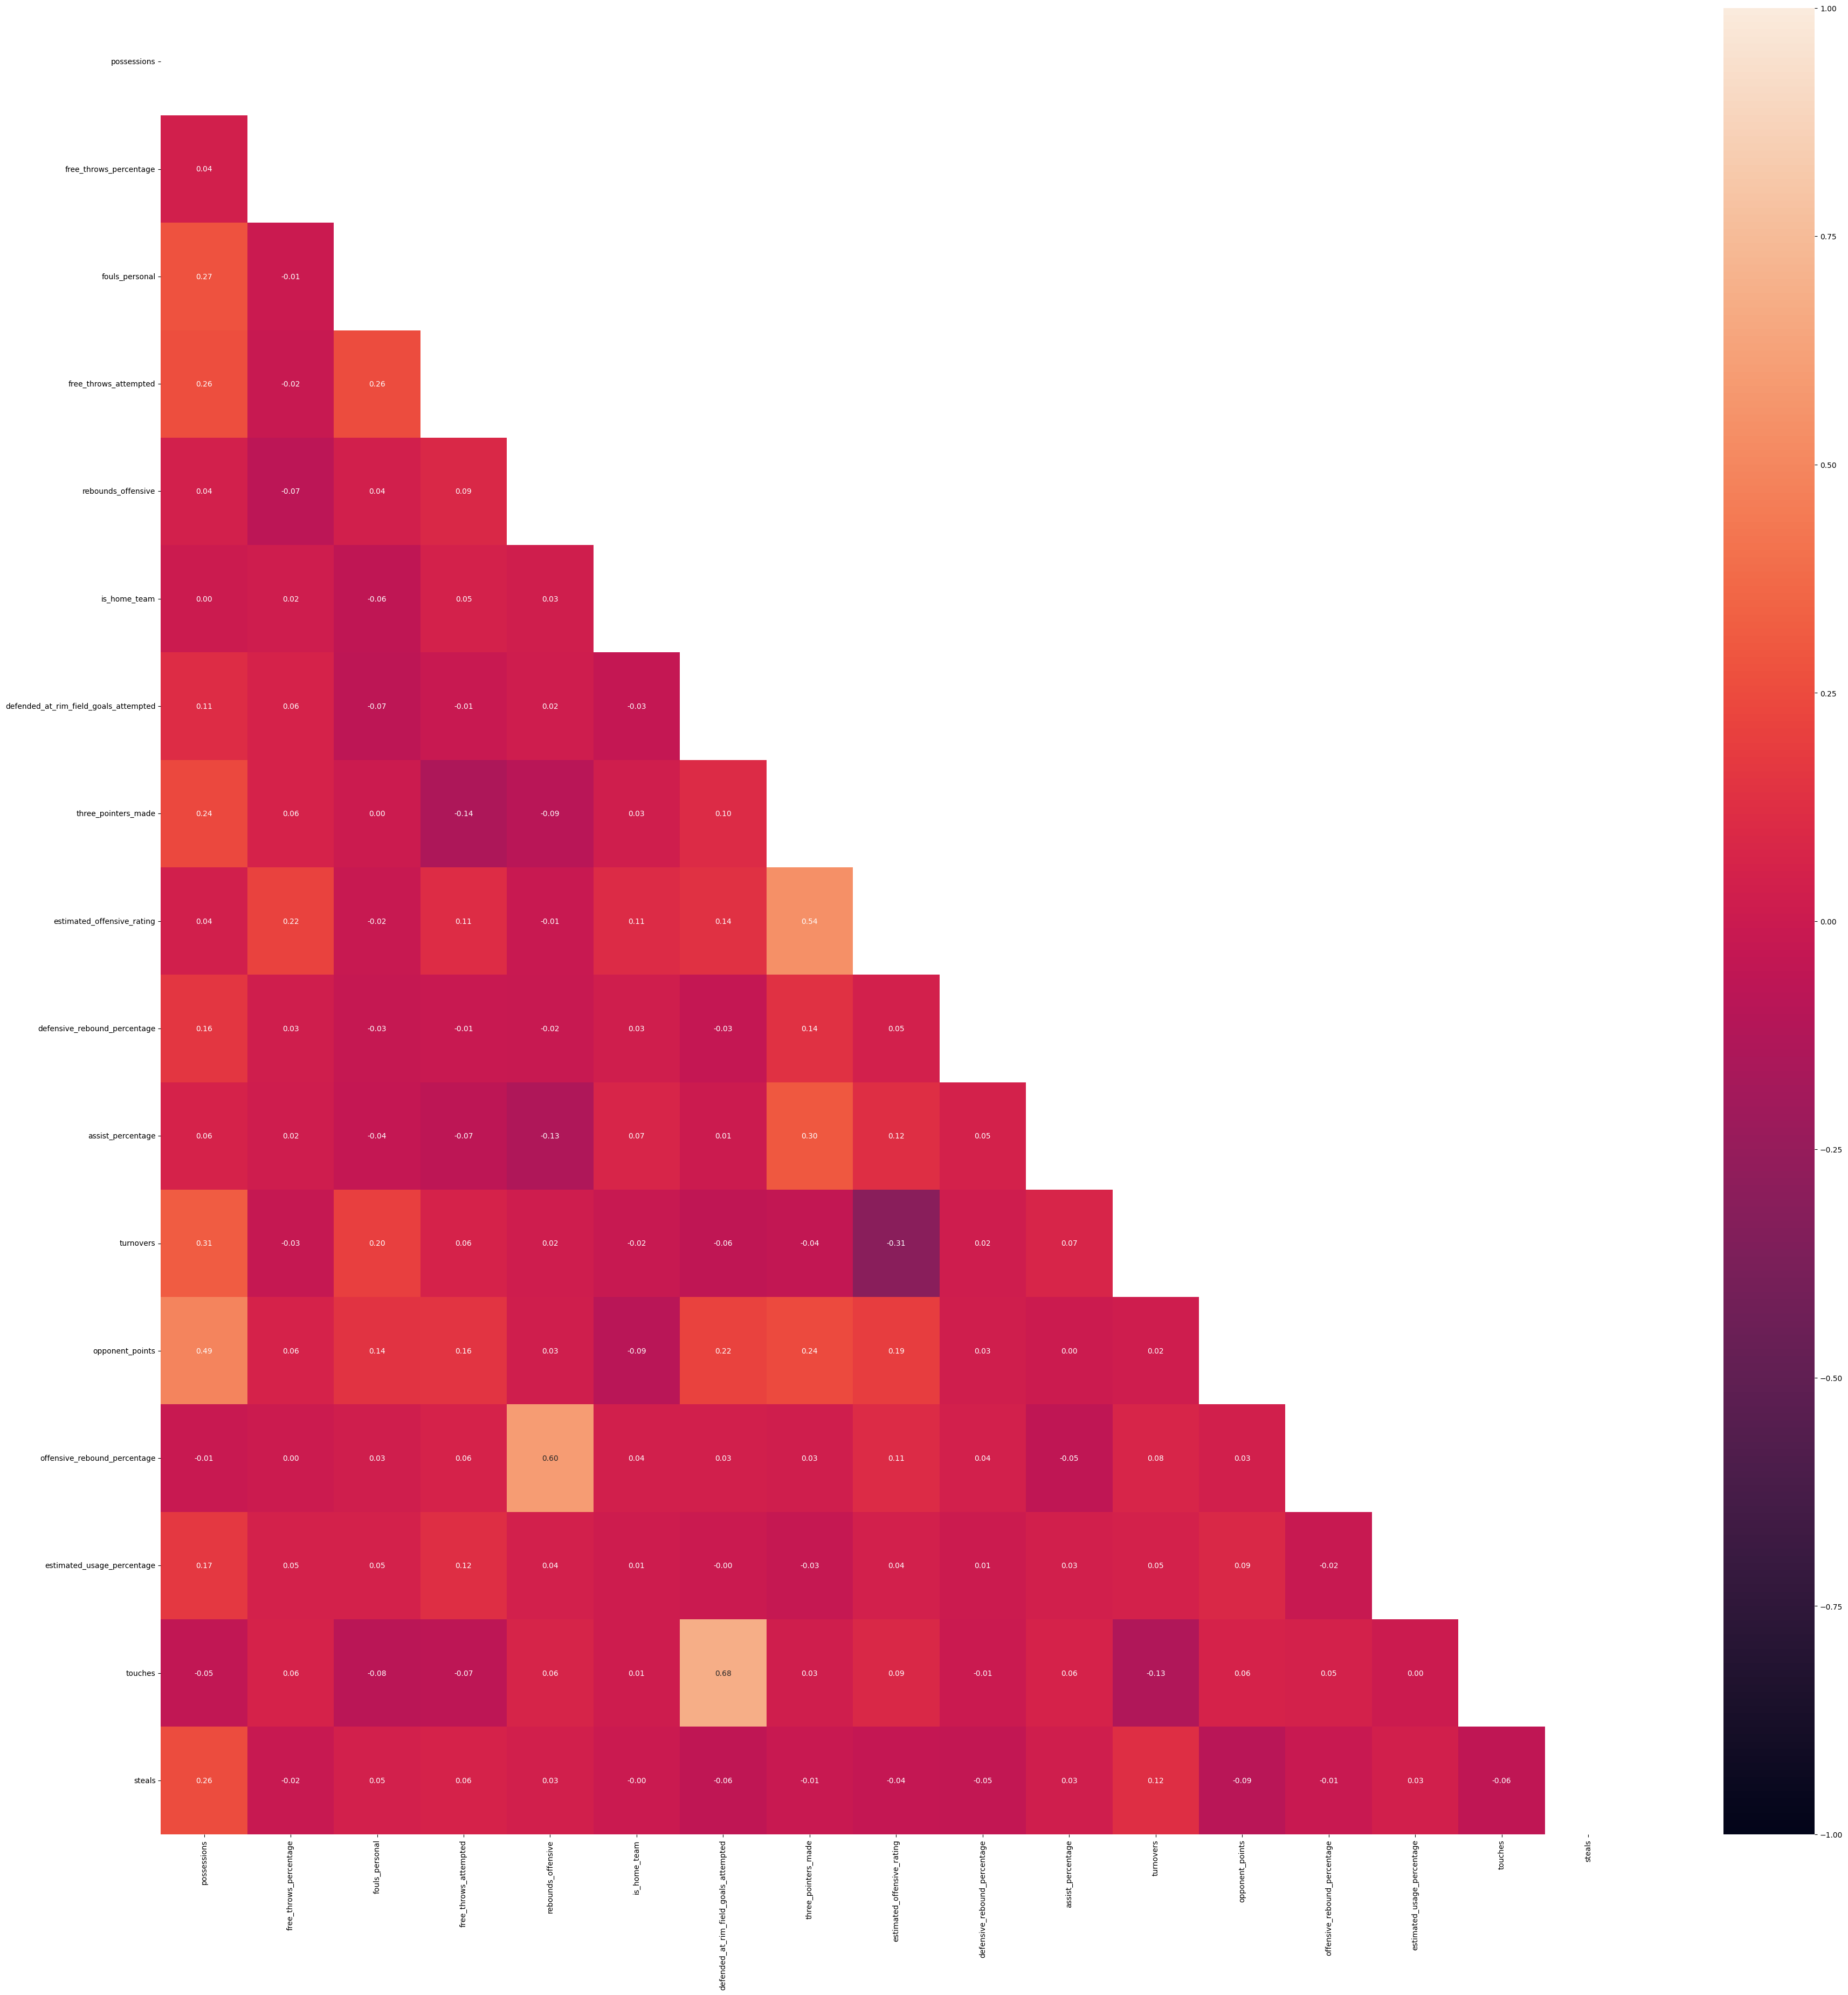

In [12]:
my_corrplot(nu_pca_df_1,'points')

In [13]:
nu_pca_df_2.head()

,points,possessions,contested_field_goals_made,is_home_team,estimated_team_turnover_percentage,defensive_rebound_percentage,defended_at_rim_field_goals_attempted,offensive_rebound_percentage,free_throws_made,estimated_usage_percentage,steals,free_throws_percentage,fouls_personal,effective_field_goal_percentage,assist_percentage,opponent_points
12495,104.0,89.0,18.0,1,8.877,0.750,24.0,0.178,18.0,0.200,5.0,0.783,21.0,0.551,0.676,87.0
12496,86.0,85.0,14.0,1,14.977,0.000,19.0,0.000,13.0,0.203,7.0,0.650,25.0,0.514,0.406,107.0
12497,92.0,85.0,16.0,1,22.841,0.733,20.0,0.229,18.0,0.199,8.0,0.750,26.0,0.597,0.531,111.0
12498,96.0,88.0,17.0,1,12.115,0.000,24.0,0.260,12.0,0.196,7.0,0.600,20.0,0.512,0.722,98.0
12499,110.0,95.0,23.0,1,24.038,0.814,21.0,0.258,17.0,0.199,8.0,0.773,14.0,0.684,0.750,95.0


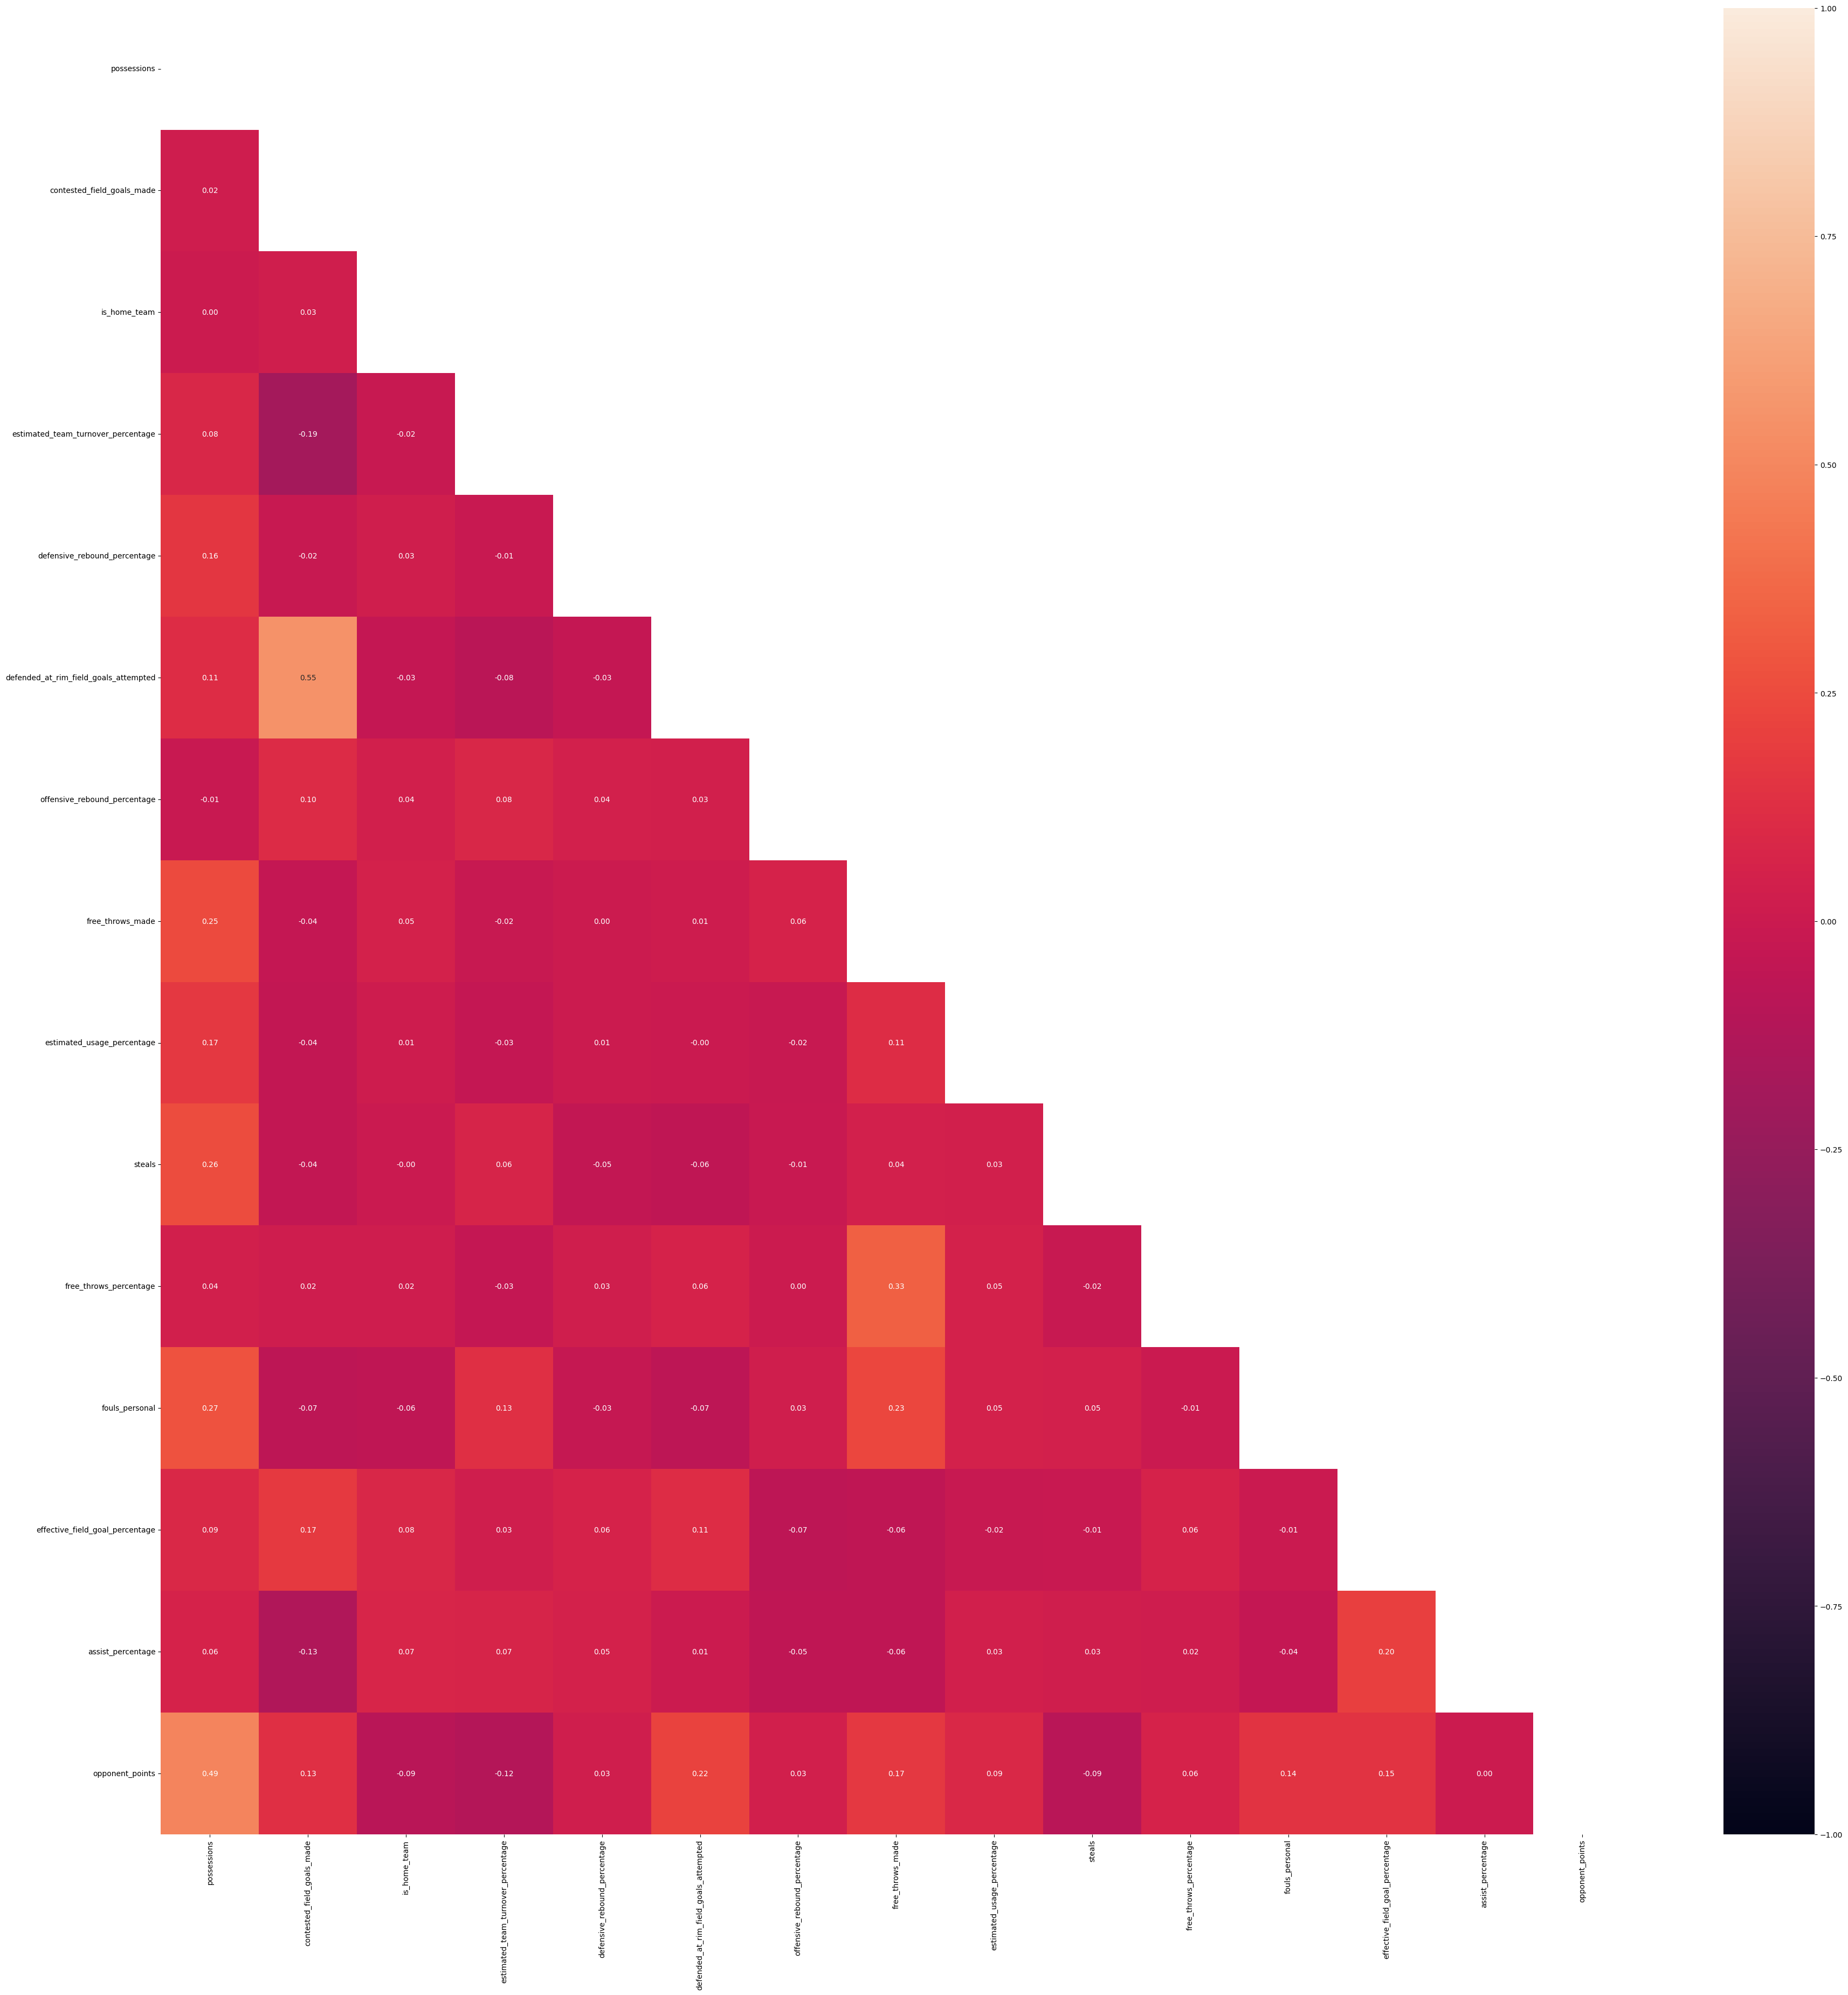

In [14]:
my_corrplot(nu_pca_df_2, 'points')

Now both datasets have no multicollinearity, and we can continue to preprocess the data.

### Removing Near-Zero Variance

Now we also need to remove variables with near-zero variance. This is to remove variables that may appear in the model but are not truly explanatory. Here is the function that removes these variables.

In [15]:
'''
remove_nzv_features removes features in the DataFrame with a variance below the parameter threshold. 
This is done by creating a mask using the sklearn VarianceThreshold function.

returns a tuple of the dataframe with the selected features (retained_df) and a dataframe of the dropped features (dropped_df)
'''
def remove_nzv_features(df:pd.DataFrame, threshold=.1): 
    from sklearn.feature_selection import VarianceThreshold

    vThreshold = VarianceThreshold(threshold)
    vThreshold.fit_transform(df)

    # Get boolean mask for selected columns
    mask = vThreshold.get_support()
    
    # Select columns to keep and drop
    selected_columns = df.columns[mask]
    dropped_columns = df.columns[~mask]
    
    # Create DataFrames for retained and removed features
    retained_df = df[selected_columns]
    dropped_df = df[dropped_columns]

    return retained_df, dropped_df


In [16]:
# Remove the Variance
res_nzv_1 = remove_nzv_features(nu_X1)
res_nzv_2 = remove_nzv_features(nu_X2)

# Assign them to new DFs
no_nzv_pca_df_1 = res_nzv_1[0]
no_nzv_pca_df_2 = res_nzv_2[0]

In [17]:
# Examine the Dropped Features
res_nzv_1[1].head()

,free_throws_percentage,defensive_rebound_percentage,assist_percentage,offensive_rebound_percentage,estimated_usage_percentage
12495,0.783,0.750,0.676,0.178,0.200
12496,0.650,0.000,0.406,0.000,0.203
12497,0.750,0.733,0.531,0.229,0.199
12498,0.600,0.000,0.722,0.260,0.196
12499,0.773,0.814,0.750,0.258,0.199


In [18]:
res_nzv_2[1].head()

,defensive_rebound_percentage,offensive_rebound_percentage,estimated_usage_percentage,free_throws_percentage,effective_field_goal_percentage,assist_percentage
12495,0.750,0.178,0.200,0.783,0.551,0.676
12496,0.000,0.000,0.203,0.650,0.514,0.406
12497,0.733,0.229,0.199,0.750,0.597,0.531
12498,0.000,0.260,0.196,0.600,0.512,0.722
12499,0.814,0.258,0.199,0.773,0.684,0.750


### Scaling

Lastly, we need to scale (or normalize) the data. This isn't necessary for MLR, but it is good practice for ML models we might use later.

In [19]:
def scale_features(df:pd.DataFrame):
    from sklearn.preprocessing import StandardScaler

    df_std = StandardScaler().fit_transform(df)
    cleaned = pd.DataFrame(df_std, columns=df.columns)
    orig_df = df

    return cleaned, orig_df

In [20]:
pca_df_scaled_1 = scale_features(no_nzv_pca_df_1)[0]
pca_df_scaled_2 = scale_features(no_nzv_pca_df_2)[0]

In [21]:
pca_df_scaled_1.head(10)

,possessions,fouls_personal,free_throws_attempted,rebounds_offensive,is_home_team,defended_at_rim_field_goals_attempted,three_pointers_made,estimated_offensive_rating,turnovers,opponent_points,touches,steals
0,-1.556456,0.172863,0.017187,-1.131782,1.0,0.038488,0.313264,0.684853,-1.411674,-1.520650,0.777839,-0.903382
1,-2.188924,1.072806,-0.387967,-1.131782,1.0,-0.539540,-0.410526,-0.679470,-0.160943,-0.055285,-0.078071,-0.226667
2,-2.188924,1.297792,0.152238,-1.394658,1.0,-0.423934,-0.169263,-0.177265,1.590081,0.237788,-0.230233,0.111690
3,-1.714573,-0.052123,-0.387967,0.182599,1.0,0.038488,0.313264,-0.127045,-0.661235,-0.714699,0.483026,-0.226667
4,-0.607754,-1.402038,-0.117864,-1.394658,1.0,-0.308329,0.554527,0.651373,2.090373,-0.934504,0.530576,0.111690
5,1.447767,1.972750,1.367699,-0.868906,1.0,0.500910,-0.651790,-0.796652,1.339935,0.311056,-0.620148,0.450048
6,-2.030807,0.397849,-0.252916,-0.606030,1.0,-1.464383,0.072000,2.124508,-1.161527,-1.154309,-0.173172,-0.226667
7,-0.923988,-0.277109,0.962545,-0.080278,1.0,-0.423934,0.554527,1.764594,-0.411089,-1.374113,0.587637,-0.565025
8,-2.188924,-0.952066,-0.117864,1.496979,1.0,-1.579989,-1.134317,0.216129,-0.411089,-1.300845,0.226252,1.465121
9,-0.923988,-0.052123,1.097597,-1.394658,1.0,0.385304,-0.893053,0.617893,-1.661820,-1.154309,-0.344355,1.465121


In [22]:
pca_df_scaled_2.head(10)

,possessions,contested_field_goals_made,is_home_team,estimated_team_turnover_percentage,defended_at_rim_field_goals_attempted,free_throws_made,steals,fouls_personal,opponent_points
0,-1.556456,0.221597,1.0,-1.375368,0.038488,0.074860,-0.903382,0.172863,-1.520650
1,-2.188924,-0.450917,1.0,0.208526,-0.539540,-0.753230,-0.226667,1.072806,-0.055285
2,-2.188924,-0.114660,1.0,2.250452,-0.423934,0.074860,0.111690,1.297792,0.237788
3,-1.714573,0.053469,1.0,-0.534606,0.038488,-0.918849,-0.226667,-0.052123,-0.714699
4,-0.607754,1.062240,1.0,2.561259,-0.308329,-0.090758,0.111690,-1.402038,-0.934504
5,1.447767,0.221597,1.0,1.061493,0.500910,1.896658,0.450048,1.972750,0.311056
6,-2.030807,0.389726,1.0,-0.443467,-1.464383,0.074860,-0.226667,0.397849,-1.154309
7,-0.923988,-0.282789,1.0,-0.263786,-0.423934,1.399804,-0.565025,-0.277109,-1.374113
8,-2.188924,0.557854,1.0,0.305897,-1.579989,-0.753230,1.465121,-0.952066,-1.300845
9,-0.923988,0.725983,1.0,-1.696821,0.385304,1.068568,1.465121,-0.052123,-1.154309


Now we have 2 scaled dataframes to create the models with.

## MLR Model

### 1st set of PCA features (`feat_list_1`)

In [23]:
from sklearn.model_selection import train_test_split

final_2 = pd.concat([pca_df_scaled_2, y2], axis=1).dropna()

X = final_2.loc[:, final_2.columns != 'points']
y = final_2.loc[:, final_2.columns == 'points']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2142)

In [24]:
import statsmodels.api as sm

train_X = sm.add_constant(X_train)

model = sm.OLS(y_train, train_X).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 points   R-squared:                       0.062
Model:                            OLS   Adj. R-squared:                  0.061
Method:                 Least Squares   F-statistic:                     88.18
Date:                Tue, 11 Mar 2025   Prob (F-statistic):          1.14e-159
Time:                        14:31:58   Log-Likelihood:                -47992.
No. Observations:               12025   AIC:                         9.600e+04
Df Residuals:                   12015   BIC:                         9.608e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=========================================================================================================
                                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                   105.9479      0.165    643.373      0.000     105.625     106.271
possessions                               0.8500      0.153      5.541      0.000       0.549       1.151
contested_field_goals_made               -0.2303      0.146     -1.574      0.115      -0.517       0.056
is_home_team                             -4.5145      0.166    -27.183      0.000      -4.840      -4.189
estimated_team_turnover_percentage       -0.4609      0.124     -3.718      0.000      -0.704      -0.218
defended_at_rim_field_goals_attempted     0.0647      0.145      0.445      0.656      -0.220       0.349
free_throws_made                         -0.3349      0.128     -2.621      0.009      -0.585      -0.084
steals                                   -0.0644      0.129     -0.498      0.618      -0.318       0.189
fouls_personal                           -0.4647      0.126     -3.687      0.000      -0.712      -0.218
opponent_points                           0.5427      0.150      3.625      0.000       0.249       0.836
==============================================================================
Omnibus:                      703.407   Durbin-Watson:                   2.006
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3007.449
Skew:                          -0.067   Prob(JB):                         0.00
Kurtosis:                       5.446   Cond. No.                         2.51
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

interpreting results:

- fixing crappy R2: iterate through and remove highest p-value, re-run regression, compare to recursive feature elimination (step-wise regression)

- When we get a huge coeff: run a hypothesis test (ttest between ind and dep)

- remove influential observations, **outlier analysis**, residual plots, variable transformations are topics to consider if we run out of ways to improve all

## Iteratively removing High P-Values

We want to take this model and iteratively remove the feature with the highest p-value. Then, the regression with the reduced features should be re-run, and this process continues until there are no more features.

Each time a regression model is created, its R<sup>2</sup> and Adj. R<sup>2</sup> should be stored in a list as a tuple. The list of features should also be stored.

Once the loop ends, find the top 3 feature lists with the highest R<sup>2</sup>, and create models for each for us to evaluate

In [25]:
import statsmodels.api as sm
import pandas as pd

# Add constant to predictor variables
train_X = sm.add_constant(X_train)

# Lists to store model performance and feature sets
r2_scores = []
adj_r2_scores = []
feature_sets = []

# Start with all features
remaining_features = list(train_X.columns)

while len(remaining_features) > 1:
    # Fit the model with the current set of features
    model = sm.OLS(y_train, train_X[remaining_features]).fit()
    
    # Store R², Adjusted R², and feature list
    r2_scores.append(model.rsquared)
    adj_r2_scores.append(model.rsquared_adj)
    feature_sets.append(remaining_features.copy())

    # Find the feature with the highest p-value
    worst_feature = model.pvalues.idxmax()

    # Stop if the worst p-value is below the threshold (e.g., 0.05)
    if model.pvalues[worst_feature] < 0.001:
        break

    # Remove the worst feature
    remaining_features.remove(worst_feature)

# Convert to DataFrame for ranking
results_df = pd.DataFrame({
    "R2": r2_scores,
    "Adj_R2": adj_r2_scores,
    "Features": feature_sets
})

# Select top 3 models based on highest Adjusted R² (primary) and R² (secondary)
top_3_models = results_df.nlargest(3, ['Adj_R2', 'R2'])

# Rebuild and print summaries for the top 3 models
for i, row in top_3_models.iterrows():
    best_features = row["Features"]
    best_model = sm.OLS(y_train, train_X[best_features]).fit()
    print(f"\n--- Model {i+1} ---")
    print(best_model.summary())



--- Model 3 ---
                            OLS Regression Results                            
Dep. Variable:                 points   R-squared:                       0.062
Model:                            OLS   Adj. R-squared:                  0.061
Method:                 Least Squares   F-statistic:                     113.3
Date:                Tue, 11 Mar 2025   Prob (F-statistic):          1.27e-161
Time:                        14:31:59   Log-Likelihood:                -47992.
No. Observations:               12025   AIC:                         9.600e+04
Df Residuals:                   12017   BIC:                         9.606e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------

In [26]:
def find_best_models(x_train,y_train):
    import statsmodels.api as sm

    x = x_train
    y = y_train

    r2_list = []
    feat_lists = []

    train_X = sm.add_constant(x)
    model = sm.OLS(y_train, train_X).fit()
    p_values = model.pvalues.tolist().sort(reverse=True)
    r2_list.append(model.rsquared, model.rsquared_adj)
    feat_lists.append(model.params.index.tolist())
    


In [27]:

from sklearn.linear_model import Lasso
import pandas as pd

# Function to iteratively remove features based on Lasso coefficients
def lasso_feature_selection(X_train, y_train, alpha=0.01):
    remaining_features = list(X_train.columns)
    r2_scores = []
    adj_r2_scores = []
    feature_sets = []

    while len(remaining_features) > 1:
        lasso = Lasso(alpha=alpha)
        lasso.fit(X_train[remaining_features], y_train)

        # Get R2 and adjusted R2
        r2 = lasso.score(X_train[remaining_features], y_train)
        adj_r2 = 1 - (1 - r2) * (len(y_train) - 1) / (len(y_train) - len(remaining_features) - 1)

        # Store results
        r2_scores.append(r2)
        adj_r2_scores.append(adj_r2)
        feature_sets.append(remaining_features.copy())

        # Find the feature with the smallest absolute coefficient
        coef_series = pd.Series(lasso.coef_, index=remaining_features)
        worst_feature = coef_series.abs().idxmin()

        # Remove the worst feature
        remaining_features.remove(worst_feature)

    return pd.DataFrame({"R2": r2_scores, "Adj_R2": adj_r2_scores, "Features": feature_sets})

# Run Lasso feature selection
lasso_results = lasso_feature_selection(X_train, y_train)

# Get top 3 models
top_lasso_models = lasso_results.nlargest(3, ["Adj_R2", "R2"])
print(top_lasso_models)


         R2    Adj_R2                                           Features
2  0.061917  0.061370  [possessions, contested_field_goals_made, is_h...
1  0.061938  0.061313  [possessions, contested_field_goals_made, is_h...
3  0.061723  0.061254  [possessions, is_home_team, estimated_team_tur...


In [28]:

from sklearn.linear_model import Ridge

# Function to iteratively remove features based on Ridge coefficients
def ridge_feature_selection(X_train, y_train, alpha=1.0):
    remaining_features = list(X_train.columns)
    r2_scores = []
    adj_r2_scores = []
    feature_sets = []

    while len(remaining_features) > 1:
        ridge = Ridge(alpha=alpha)
        ridge.fit(X_train[remaining_features], y_train)

        # Get R2 and adjusted R2
        r2 = ridge.score(X_train[remaining_features], y_train)
        adj_r2 = 1 - (1 - r2) * (len(y_train) - 1) / (len(y_train) - len(remaining_features) - 1)

        # Store results
        r2_scores.append(r2)
        adj_r2_scores.append(adj_r2)
        feature_sets.append(remaining_features.copy())

        # Find the feature with the smallest absolute coefficient
        coef_series = pd.Series(ridge.coef_, index=remaining_features)
        worst_feature = coef_series.abs().idxmin()

        # Remove the worst feature
        remaining_features.remove(worst_feature)

    return pd.DataFrame({"R2": r2_scores, "Adj_R2": adj_r2_scores, "Features": feature_sets})

# Run Ridge feature selection
ridge_results = ridge_feature_selection(X_train, y_train)

# Get top 3 models
top_ridge_models = ridge_results.nlargest(3, ["Adj_R2", "R2"])
print(top_ridge_models)


         R2    Adj_R2                                           Features
2  0.061922  0.061376  [possessions, contested_field_goals_made, is_h...
1  0.061940  0.061316  [possessions, contested_field_goals_made, is_h...
3  0.061727  0.061259  [possessions, is_home_team, estimated_team_tur...


In [29]:

import statsmodels.api as sm

# Stepwise feature selection using p-values
def stepwise_feature_selection(X_train, y_train, p_value_threshold=0.05):
    remaining_features = list(X_train.columns)
    r2_scores = []
    adj_r2_scores = []
    feature_sets = []

    while len(remaining_features) > 1:
        model = sm.OLS(y_train, sm.add_constant(X_train[remaining_features])).fit()

        # Get R2 and adjusted R2
        r2_scores.append(model.rsquared)
        adj_r2_scores.append(model.rsquared_adj)
        feature_sets.append(remaining_features.copy())

        # Find feature with highest p-value
        worst_feature = model.pvalues.drop("const").idxmax()

        # Stop if all p-values are below threshold
        if model.pvalues[worst_feature] < p_value_threshold:
            break

        # Remove the worst feature
        remaining_features.remove(worst_feature)

    return pd.DataFrame({"R2": r2_scores, "Adj_R2": adj_r2_scores, "Features": feature_sets})

# Run stepwise feature selection
stepwise_results = stepwise_feature_selection(X_train, y_train)

# Get top 3 models
top_stepwise_models = stepwise_results.nlargest(3, ["Adj_R2", "R2"])
print(top_stepwise_models)


         R2    Adj_R2                                           Features
2  0.061922  0.061376  [possessions, contested_field_goals_made, is_h...
1  0.061944  0.061319  [possessions, contested_field_goals_made, is_h...
3  0.061727  0.061259  [possessions, is_home_team, estimated_team_tur...
